In [1]:
import multiprocessing
import os
from functools import partial

os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

import matplotlib.pyplot as plt
import numpy as np
import torch

from utils import TeacherNetwork, draw_teacher_dirs, get_results, plot_trajectory, style_heatmaps

In [2]:
def get_delta(scale, alpha):
    return scale**2 * (1/alpha**2 - alpha**2)

In [3]:
# (scale, delta)
experiments = [
    (0.1, get_delta(0.1, 1)),
    (2, get_delta(2, 1)),
    (0.1, get_delta(0.1, 0.1)),
    (0.1, get_delta(0.1, 10))
]

m = 50
n = 20
d = 2
n_iter = 1_000_000
base_lr = 1e-4  # was this it? Yes, it seems so.

W=(3, 2), a=(1, 3)
[[-1. -1.  1.]]


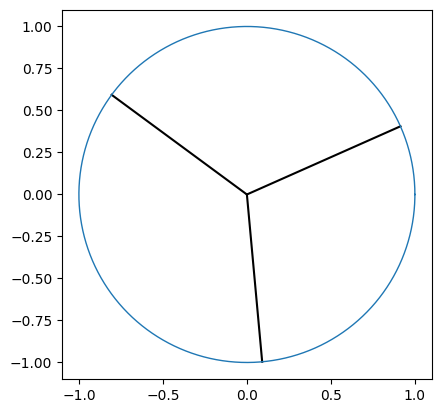

In [4]:
torch.manual_seed(15)

input_size = d
m0 = 3

# Initialize teacher and student networks
teacher = TeacherNetwork(input_size, m0)

# Visualize teacher directions to make sure it's a nice spread
# (could also hard-code them for this toy setting)
W = teacher.fc1.weight.data.clone().numpy()
a = teacher.fc2.weight.data.clone().numpy()
print(f"W={W.shape}, a={a.shape}")
fig, ax = plt.subplots(1, 1)
for i in range(m0):
    w_i = W[i, :]
    a_i = a[0, i]
    ax.plot((0, np.abs(a_i) * w_i[0]), (0, np.abs(a_i) * w_i[1]), c='k')
print(a)
_t = np.linspace(0, 2 * np.pi, 1_000)
ax.plot(np.cos(_t), np.sin(_t), linewidth=1)
ax.set_aspect('equal', adjustable='box')

In [5]:
with multiprocessing.Pool(len(experiments)) as _p:
    out = _p.starmap(
        partial(get_results, seed=100, lr=base_lr, n_iter=n_iter, teacher=teacher, n_samples=n, m=m, input_size=d, leak_parameter=None, checkpoints_to_save=None), experiments)

results = {}
for _arg, _results in zip(experiments, out):
    # Just leave the learning rate out of the dictionary
    results[_arg] = _results

input mean: 0.08544959127902985, label mean: -0.4403972625732422input mean: 0.08544959127902985, label mean: -0.4403972625732422input mean: 0.08544959127902985, label mean: -0.4403972625732422input mean: 0.08544959127902985, label mean: -0.4403972625732422



Training took 23.618616104125977 s
Rest took 0.004082918167114258 s
Training took 23.704917192459106 s
Rest took 0.0035521984100341797 s
Training took 23.714451551437378 s
Rest took 0.0035016536712646484 s
Training took 23.772820949554443 s
Rest took 0.006007194519042969 s


In [6]:
print(results.keys())

dict_keys([(0.1, 0.0), (2, 0.0), (0.1, 0.9999), (0.1, -0.9999000000000001)])


In [50]:
def plot_trajectory(W, a, ax):
    # Verify shapes
    n_steps, m, d = W.shape
    assert d == 2
    assert a.shape == (n_steps, m)

    betas = W * np.abs(a[:, :, None])
    # betas = W

    # Plot one neuron's trajectory at a time
    for i in range(m):
        final_a_i_sign = np.sign(a[-1, i])
        ax.plot(betas[:, i, 0], betas[:, i, 1], lw=1, c="k", alpha=0.5)
        color = 'blue' if final_a_i_sign >= 0 else 'red'  # FIXME: flip these?
        ax.scatter(betas[-1, i, 0], betas[-1, i, 1], color=color, s=30, alpha=0.6, zorder=10)


def draw_init_circle(radius, ax):
    _t = np.linspace(0, 2 * np.pi, 1_000)
    ax.plot(radius * np.cos(_t), radius * np.sin(_t), linewidth=1, color="k", zorder=100)


def draw_teacher_dirs(W, a, ax):
    m0 = W.shape[0]
    assert a.shape == (1, m0)
    for i in range(m0):
        w_i = W[i, :]
        a_i = a[0, i]
        color = 'blue' if a_i >= 0 else 'red'  # FIXME: flip these?
        ax.plot((0, 10 * np.abs(a_i) * w_i[0]), (0, 10 * np.abs(a_i) * w_i[1]), linestyle="--", c=color)  # c='k')

    # Make a circle
    # _t = np.linspace(0, 2 * np.pi, 1_000)
    # ax.plot(np.cos(_t), np.sin(_t), linewidth=1)

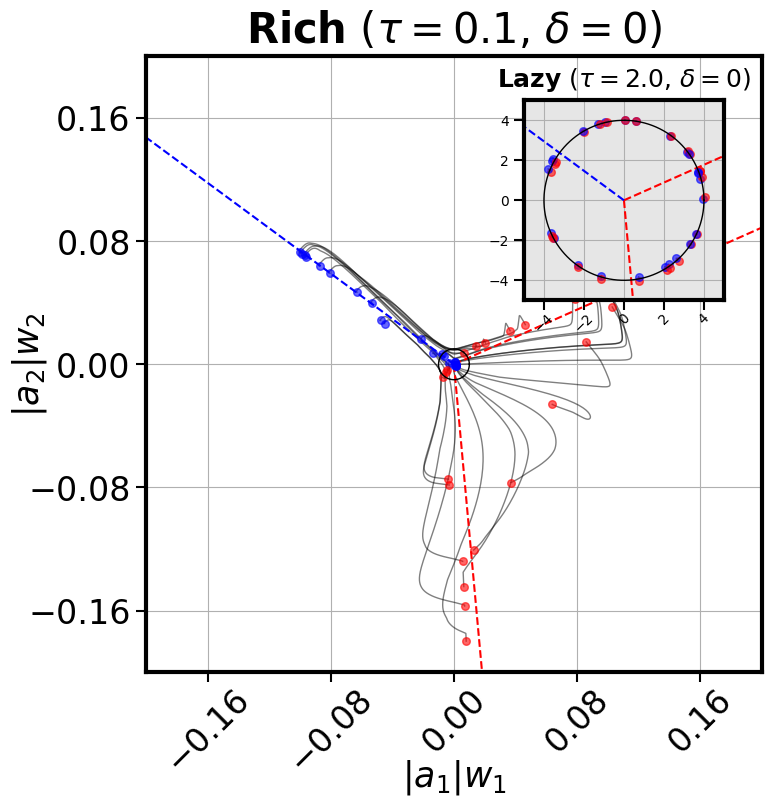

In [95]:
# Create the main plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("$\\bf{Rich}$ ($\\tau = 0.1$, $\delta=0$)", fontsize=30, pad=10)
ax.set_xlabel("$|a_1|w_1$", labelpad=-15, fontsize=25)
ax.set_ylabel("$|a_2|w_2$", labelpad=-15, fontsize=25)
ax.set_aspect('equal')
style_heatmaps(ax)

W_teacher = teacher.fc1.weight.data.clone().numpy()
a_teacher = teacher.fc2.weight.data.clone().numpy()

# Plotting in main
_Ws_nn, _as_nn = results[0.1, 0]["nn"][0:2]
plot_trajectory(_Ws_nn, _as_nn, ax)  # I think want to add teacher directions to these
draw_teacher_dirs(W_teacher, a_teacher, ax)

draw_init_circle(0.1**2, ax)

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)

ax.grid()

# Create the inset plot
inset_ax = fig.add_axes([0.6, 0.575, 0.25, 0.25]) # (left, bottom, width, height)
inset_ax.set_title("$\\bf{Lazy}$ ($\\tau = 2.0$, $\delta=0$)", fontsize=18, pad=10)
# inset_ax.set_xlabel("$|a_1|w_1$", labelpad=-3, fontsize=10)
# inset_ax.set_ylabel("$|a_2|w_2$", labelpad=-3, fontsize=10)
inset_ax.set_aspect('equal')

inset_ax.set_xlim(-5, 5)
inset_ax.set_ylim(-5, 5)

style_heatmaps(inset_ax, labelsize=10)

# Plotting in inset
_Ws_nn, _as_nn = results[2, 0]["nn"][0:2]
plot_trajectory(_Ws_nn, _as_nn, inset_ax)
draw_teacher_dirs(W_teacher, a_teacher, inset_ax)

draw_init_circle(2**2, inset_ax)

inset_ax.set_facecolor((0.9, 0.9, 0.9))  # 'lightgrey', alpha=0.2)
inset_ax.grid()

# inset_ax.plot(x, y, 'r--')

# Show plot with inset
# fig.tight_layout()
plt.show()

# Save figures
if not os.path.exists("motivating"):
    os.makedirs("motivating")
# fig.tight_layout()
fig.savefig('motivating/chizat_0.pdf', bbox_inches="tight")

# Dots bigger
# Make tau, delta=0
# Initialization radius
# Directions go out in lazy (tau=2.)

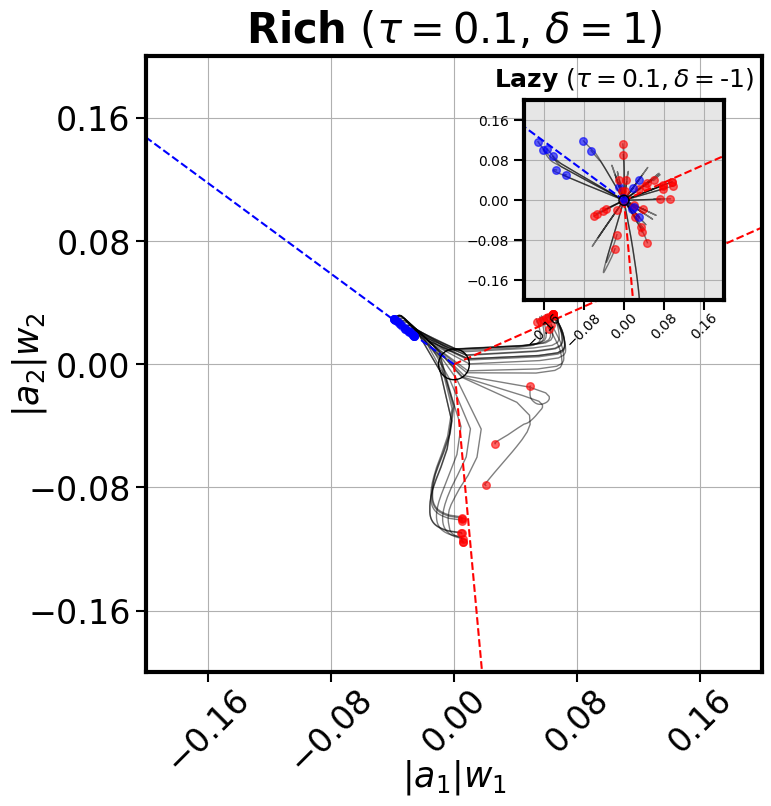

In [94]:
# Create the main plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("$\\bf{Rich}$ ($\\tau = 0.1$, $\delta = 1$)", fontsize=30, pad=10)
ax.set_xlabel("$|a_1|w_1$", labelpad=-15, fontsize=25)
ax.set_ylabel("$|a_2|w_2$", labelpad=-15, fontsize=25)
ax.set_aspect('equal')
style_heatmaps(ax)

W_teacher = teacher.fc1.weight.data.clone().numpy()
a_teacher = teacher.fc2.weight.data.clone().numpy()

# Plotting in main
# _Ws_nn, _as_nn = results[0.1, 0]["nn"][0:2]
_Ws_nn, _as_nn = results[0.1, 0.9999]["nn"][0:2]
plot_trajectory(_Ws_nn, _as_nn, ax)  # I think want to add teacher directions to these
draw_teacher_dirs(W_teacher, a_teacher, ax)

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.grid()

# Create the inset plot
inset_ax = fig.add_axes([0.6, 0.575, 0.25, 0.25]) # (left, bottom, width, height)
inset_ax.set_title("$\\bf{Lazy}$ ($\\tau = 0.1, \delta =$-1)", fontsize=18, pad=10)
# inset_ax.set_xlabel("$|a_1|w_1$", labelpad=-3, fontsize=20)
# inset_ax.set_ylabel("$|a_2|w_2$", labelpad=-3, fontsize=20)
inset_ax.set_aspect('equal')
style_heatmaps(inset_ax, labelsize=10)

# Plotting in inset
# _Ws_nn, _as_nn = results[2, 0]["nn"][0:2]
_Ws_nn, _as_nn = results[0.1, -0.9999000000000001]["nn"][0:2]
plot_trajectory(_Ws_nn, _as_nn, inset_ax)
draw_teacher_dirs(W_teacher, a_teacher, inset_ax)

draw_init_circle(0.1**2, ax)

inset_ax.set_xlim(-0.2, 0.2)
inset_ax.set_ylim(-0.2, 0.2)
draw_init_circle(0.1**2, inset_ax)

inset_ax.set_facecolor((0.9, 0.9, 0.9))  # 'lightgrey', alpha=0.2)
inset_ax.grid()

# Show plot with inset
plt.show()

# Save figures
if not os.path.exists("motivating"):
    os.makedirs("motivating")
fig.savefig('motivating/chizat_1.pdf', bbox_inches="tight")